In [146]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from radioReduction import *
from astropy.stats import LombScargle
from scipy import optimize
from scipy.interpolate import make_interp_spline, BSpline


In [150]:
# Loading in the data
dt = pd.read_table('2m1315_data_table.txt',sep=' ')

# Splitting up the data
avg = pd.DataFrame(data={'mjd':dt['MJD'],'re':dt['Average Flux ($\\mu Jy$)'],'ure':dt['err ($\\mu Jy$)']})
avg = avg[:20]
low = pd.DataFrame(data={'mjd':dt['MJD'],'re':dt['5 GHz Flux ($\\mu Jy$)'],'ure':dt['5 GHz err ($\\mu Jy$)']})
high = pd.DataFrame(data={'mjd':dt['MJD'],'re':dt['7 GHz Flux ($\\mu Jy$)'],'ure':dt['7 GHz err ($\\mu Jy$)']})

# Loading the background sources
s1 = pd.read_csv('1315/s1_lc.csv',sep=' ')
s2 = pd.read_csv('1315/s2_lc.csv',sep=' ')
s3 = pd.read_csv('1315/s3_lc.csv',sep=',')

# Putting all the sources into one array
All = pd.merge_asof(s2.sort_values('mjd'),s3.sort_values('mjd'),direction='nearest',on='mjd')
All = pd.merge_asof(All,s1.sort_values('mjd'),direction='nearest',on='mjd')
All = All.drop(columns={'Unnamed: 0_x','Unnamed: 0_y','Unnamed: 0'})

# Filling in missing epochs with 
backGround = All.rename(columns={'re_x':'s2_re', 'ure_x':'s2_ure', 're_y':'s3_re', 'ure_y':'s3_ure', 're':'s1_re','ure':'s1_ure'})

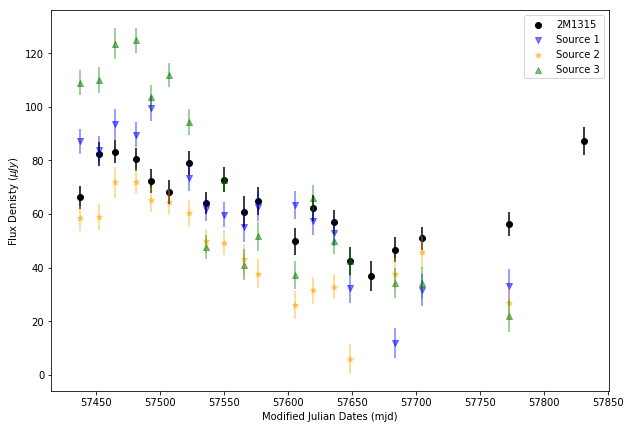

In [151]:
# Plotting the sources
plt.figure(figsize=(10,7))
plt.scatter(avg['mjd'],avg['re'],color='black',marker='o',label='2M1315')
plt.errorbar(avg['mjd'],avg['re'],color='black',yerr=avg['ure'],linestyle='None',label='_nolegend_')

sources = [s1,s2,s3]
colors = ['blue','orange','green']
markers = ['v','*','^']
j = 0
for i in sources:
    plt.scatter(i['mjd'],i['re'],color=colors[j],marker=markers[j],label='Source %s'%(j+1),alpha=0.5)
    plt.errorbar(i['mjd'],i['re'],color=colors[j],yerr=i['ure'],linestyle='None',label='_nolegend_',alpha=0.5)
    j = j + 1
plt.legend(loc='best')
plt.xlabel('Modified Julian Dates (mjd)')
plt.ylabel('Flux Denisty ($\mu Jy$)')
plt.savefig('plots/1315_background.png')
plt.show()

In [152]:
# Creating an average light curves of all the background sources
avgBack = (s1['re']+s2['re']+s3['re'])/3
avgBackErr = np.sqrt(s1['ure']**2+s2['ure']**2+s3['ure']**2)/3

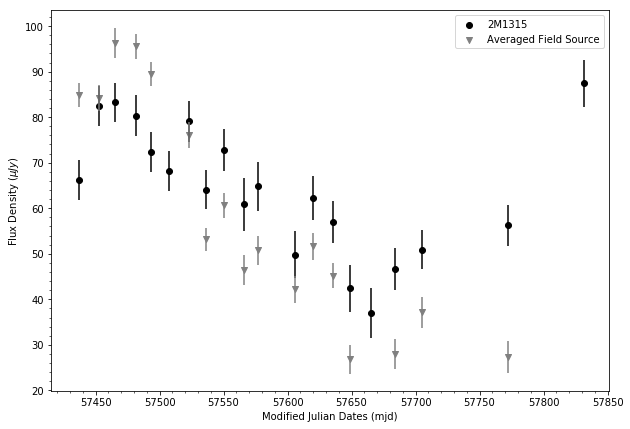

In [153]:
# Plotting the average background light curve
plt.figure(figsize=(10,7))
plt.scatter(avg['mjd'],avg['re'],color='black',marker='o',label='2M1315')
plt.errorbar(avg['mjd'],avg['re'],color='black',yerr=avg['ure'],linestyle='None',label='_nolegend_')
plt.scatter(s2['mjd'],avgBack,color='gray',marker='v',label='Averaged Field Source')
plt.errorbar(s2['mjd'],avgBack,yerr=avgBackErr,color='gray',linestyle='None',label='_nolabel_')
plt.legend(loc='best')
plt.xlabel('Modified Julian Dates (mjd)')
plt.ylabel('Flux Density ($\mu Jy$)')
plt.minorticks_on()
plt.savefig('plots/1315_avgFieldSource.png')
plt.show()

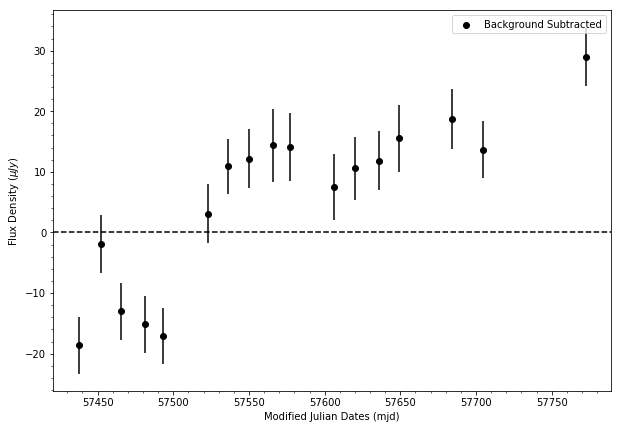

In [154]:
# Subtracting the background light curve and plotting
bgSubbed = avg['re'] - avgBack
bgSubbedErr = np.sqrt(avg['ure']**2+avgBackErr)

plt.figure(figsize=(10,7))
plt.scatter(avg['mjd'],bgSubbed,color='k',marker='o',label='Background Subtracted')
plt.errorbar(avg['mjd'],bgSubbed,color='k',yerr=bgSubbedErr,linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='k',linestyle='dashed')
plt.legend(loc='best')
plt.xlabel('Modified Julian Dates (mjd)')
plt.ylabel('Flux Density ($\mu Jy$)')
plt.minorticks_on()
plt.show()


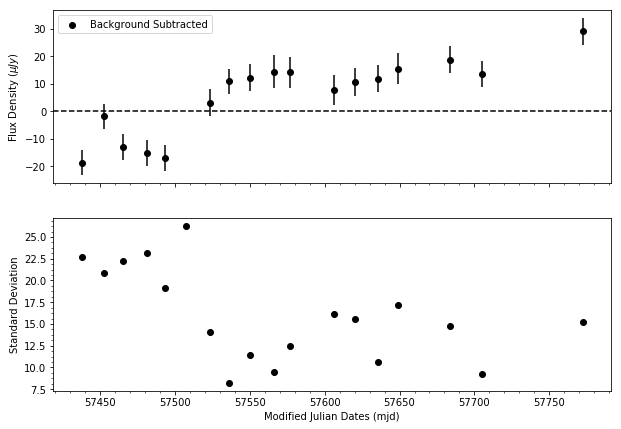

In [164]:
# Calculating standard deviation epoch
std = pd.merge_asof(backGround,avg,on='mjd',direction='nearest')
stdValues = std[['s1_re','s2_re','s3_re','re']].std(axis=1)

# Plotting subtracted values and standard deviation
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(10,7),sharex=True,gridspec_kw={'height_ratios':[1,1]})

ax[0].scatter(avg['mjd'],bgSubbed,color='k',marker='o',label='Background Subtracted')
ax[0].errorbar(avg['mjd'],bgSubbed,color='k',yerr=bgSubbedErr,linestyle='None',label='_nolegend_')
ax[0].axhline(y=0,color='k',linestyle='dashed')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($\mu Jy$)')

ax[1].scatter(std['mjd'],stdValues,color='k',marker='o')
ax[1].set_ylabel('Standard Deviation')

plt.minorticks_on()
plt.xlabel('Modified Julian Dates (mjd)')
plt.show()

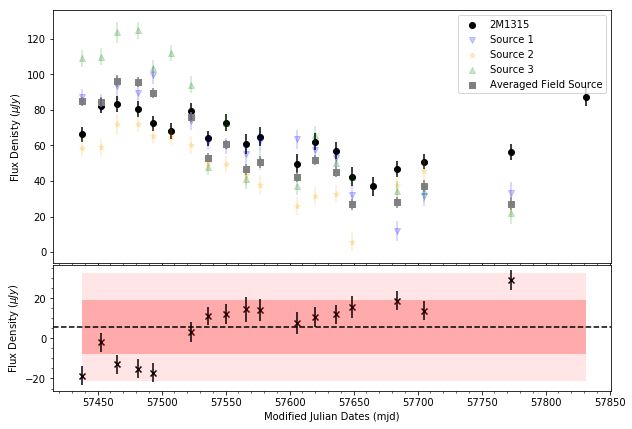

In [184]:
# Calculating the standard deviation of the subtracted model
bgStd = np.std(bgSubbed)
bgMean = np.mean(bgSubbed)
lowSigma1 = bgMean - bgStd
uppSigma1 = bgMean + bgStd
lowSigma2 = bgMean - 2*bgStd
uppSigma2 = bgMean + 2*bgStd

# Plotting the sources and the standard deviation
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,7),sharex=True,gridspec_kw={'hspace':0.01,'height_ratios':[4,2]})

# Plotting the Sources
sources = [s1,s2,s3]
colors = ['blue','orange','green']
markers = ['v','*','^']
ax[0].scatter(avg['mjd'],avg['re'],color='black',marker='o',label='2M1315')
ax[0].errorbar(avg['mjd'],avg['re'],color='black',yerr=avg['ure'],linestyle='None',label='_nolegend_')
j = 0
for i in sources:
    ax[0].scatter(i['mjd'],i['re'],color=colors[j],marker=markers[j],label='Source %s'%(j+1),alpha=0.2)
    ax[0].errorbar(i['mjd'],i['re'],color=colors[j],yerr=i['ure'],linestyle='None',label='_nolegend_',alpha=0.2)
    j = j + 1
ax[0].scatter(s2['mjd'],avgBack,color='gray',marker='s',label='Averaged Field Source')
ax[0].errorbar(s2['mjd'],avgBack,yerr=avgBackErr,color='gray',linestyle='None',label='_nolabel_')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Denisty ($\mu Jy$)')

# Plotting background subtracted values
ax[1].scatter(avg['mjd'],bgSubbed,color='k',marker='x',label='Background Subtracted')
ax[1].errorbar(avg['mjd'],bgSubbed,color='k',yerr=bgSubbedErr,linestyle='None',label='_nolegend_')
ax[1].fill_between(avg['mjd'],lowSigma1,uppSigma1,facecolor='red',alpha=0.25,label='1 $\sigma$')
ax[1].fill_between(avg['mjd'],lowSigma2,uppSigma2,facecolor='red',alpha=0.1,label='2 $\sigma$')
ax[1].axhline(y=bgMean,color='k',linestyle='dashed')
ax[1].set_ylabel('Flux Density ($\mu Jy$)')

plt.minorticks_on()
plt.xlabel('Modified Julian Dates (mjd)')
plt.savefig('plots/1315_subtracted.png')
plt.show()